# Location model

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import time

### CART model to predict location type

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
pick_data = pd.read_csv("THD Tracy DFC - Pick Locations.csv")

/Users/alessandroesciua/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,13,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pick_data.head()

,ZONE,AISLE,BAY,LVL,LOCATION,LOCATION_TYPE,PERM / TEMP,LOC WIDTH,LOC LENGTH,LOC HEIGHT,CURR MIN,CURR MAX,SKU,DESCRIPTION,UNIT HEIGHT,UNIT WIDTH,UNIT LENGTH,UNIT WEIGHT,UNIT VOLUME,PACK FLAG,DAILY UNITS,DAILY CUBIC VELOCITY,DAILY HITS,WAVE TASK (4 WEEKS),LEAN TASK (4 WEEKS),TOTAL TASK (4 WEEKS),WEEK 1 UNITS (NEWEST),WEEK 2 UNITS,WEEK 3 UNITS,WEEK 4 UNITS (OLDEST),WEEKLY AVERAGE,ON-HAND INVENTORY,Weight > 35
0,BK1,10,45,NaN,BK1-010-045,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
1,BK1,10,46,NaN,BK1-010-046,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
2,BK1,10,47,NaN,BK1-010-047,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
3,BK1,10,48,NaN,BK1-010-048,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
4,BK1,10,49,NaN,BK1-010-049,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No


In [5]:
pick_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86393 entries, 0 to 86392
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ZONE                   86393 non-null  object 
 1   AISLE                  86393 non-null  object 
 2   BAY                    86393 non-null  int64  
 3   LVL                    84984 non-null  object 
 4   LOCATION               86393 non-null  object 
 5   LOCATION_TYPE          86213 non-null  object 
 6   PERM / TEMP            86393 non-null  object 
 7   LOC WIDTH              86393 non-null  float64
 8   LOC LENGTH             86393 non-null  float64
 9   LOC HEIGHT             86393 non-null  float64
 10  CURR MIN               13190 non-null  float64
 11  CURR MAX               13190 non-null  float64
 12  SKU                    13190 non-null  float64
 13  DESCRIPTION            13190 non-null  object 
 14  UNIT HEIGHT            13190 non-null  float64
 15  UN

In [6]:
pick_data.drop(['ZONE', 'AISLE', 'BAY','LVL', 'LOCATION', 'LOC WIDTH', 'LOC LENGTH', 'LOC HEIGHT', 
                'CURR MIN', 'CURR MAX', 'PACK FLAG', 'DAILY HITS', 'WAVE TASK (4 WEEKS)', 
               'LEAN TASK (4 WEEKS)', 'TOTAL TASK (4 WEEKS)', 'WEEK 1 UNITS (NEWEST)', 'WEEK 2 UNITS', 'WEEK 3 UNITS',
               'WEEK 4 UNITS (OLDEST)', 'WEEKLY AVERAGE'], axis=1, inplace = True)

In [7]:
pick_data = pick_data.set_index(['SKU', 'DESCRIPTION'])

In [8]:
pick_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 86393 entries, (nan, nan) to (nan, nan)
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LOCATION_TYPE         86213 non-null  object 
 1   PERM / TEMP           86393 non-null  object 
 2   UNIT HEIGHT           13190 non-null  float64
 3   UNIT WIDTH            13190 non-null  float64
 4   UNIT LENGTH           13190 non-null  float64
 5   UNIT WEIGHT           13190 non-null  float64
 6   UNIT VOLUME           13190 non-null  float64
 7   DAILY UNITS           86393 non-null  float64
 8   DAILY CUBIC VELOCITY  86393 non-null  float64
 9   ON-HAND INVENTORY     86393 non-null  int64  
 10  Weight > 35           86393 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 8.3+ MB


In [9]:
pick_data['PERM / TEMP'] = np.where(pick_data['PERM / TEMP'] == 'T', 1, 0)
pick_data['Weight > 35'] = np.where(pick_data['Weight > 35'] == 'Yes', 1, 0)
pick_data = pick_data.rename(columns={'PERM / TEMP': 'TEMP', 'Weight > 35': 'Overweight'})

In [10]:
#pick_data = pick_data.astype({'DESCRIPTION': 'string'}).dtypes

In [11]:
pick_data = pick_data.dropna()
pick_data.head()

,,LOCATION_TYPE,TEMP,UNIT HEIGHT,UNIT WIDTH,UNIT LENGTH,UNIT WEIGHT,UNIT VOLUME,DAILY UNITS,DAILY CUBIC VELOCITY,ON-HAND INVENTORY,Overweight
SKU,DESCRIPTION,,,,,,,,,,,
1.004698e+09,MINIBELTIS VICTORIAN WALL BLOCK,Bulk Floor,1,3.00,8.0,4.0,8.0,96.00,0.0,0.0,378,0
5.562110e+05,"12""X12"" GREY STEP STONE",Bulk Floor,1,1.88,12.0,12.0,20.0,270.72,0.0,0.0,168,0
9.151300e+05,"16"" X16"" RED BRICKFACE STEP STONE",Bulk Floor,1,1.88,16.0,16.0,31.1,481.28,0.0,0.0,84,0
5.408630e+05,"24""X24"" GRAY STEP STONE",Bulk Floor,1,2.00,24.0,24.0,88.0,1152.00,0.0,0.0,20,1
9.150680e+05,"12""X12"" RED STEP STONE",Bulk Floor,1,1.88,12.0,12.0,20.0,270.72,0.0,0.0,168,0


In [12]:
pick_train, pick_test = train_test_split(pick_data, test_size=0.2)

y_train = pick_train['LOCATION_TYPE']
X_train = pick_train.drop(columns = ['LOCATION_TYPE'])

y_test = pick_test['LOCATION_TYPE']
X_test = pick_test.drop(columns = ['LOCATION_TYPE'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10536, 10) (10536,)
(2634, 10) (2634,)


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10536 entries, (1000473381.0, 'GRIP-TIGHT CACHET Q3 ELONGATED CLOSE') to (1005151008.0, 'CONSTRUCTION TRIPOD')
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TEMP                  10536 non-null  int64  
 1   UNIT HEIGHT           10536 non-null  float64
 2   UNIT WIDTH            10536 non-null  float64
 3   UNIT LENGTH           10536 non-null  float64
 4   UNIT WEIGHT           10536 non-null  float64
 5   UNIT VOLUME           10536 non-null  float64
 6   DAILY UNITS           10536 non-null  float64
 7   DAILY CUBIC VELOCITY  10536 non-null  float64
 8   ON-HAND INVENTORY     10536 non-null  int64  
 9   Overweight            10536 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 1.5+ MB


In [14]:
y_train.head()

SKU           DESCRIPTION                         
1.000473e+09  GRIP-TIGHT CACHET Q3 ELONGATED CLOSE            Pick Mod - Bin
1.002854e+09  NORTHWOOD 25.67 IN. X 31.38 IN. WOOD          SR - Full Pallet
1.005131e+09  CLX OUTDOOR BLEACH 121OZ                Pick Mod - Carton Flow
1.003346e+09  0.7-CU. FT. 700 WATT  COUNTERTOP MIC          SR - Full Pallet
1.001966e+09  26" SERENITY SQ RUBBER PLANTER SLATE          SR - Full Pallet
Name: LOCATION_TYPE, dtype: object

In [15]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 101),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

            
dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=0) # default scoring metric to optimize is accuracy, used as default if none given.
dtc_cv_acc.fit(X_train, y_train)

/Users/alessandroesciua/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.0e+00, 1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05,
       7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04,
       1.4e-04, 1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04,
       2.1e-04, 2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04,
       2.8e-04, 2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3...
       7.0e-04, 7.1e-04, 7.2e-04, 7.3e-04, 7.4e-04, 7.5e-04, 7.6e-04,
       7.7e-04, 7.8e-04, 7.9e-04, 8.0e-04, 8.1e-04, 8.2e-04, 8.3e-04,
       8.4e-04, 8.5e-04, 8.6e-04, 8.7e-04, 8.8e-04, 8.9e-04, 9.0e-04,
       9.1e-04, 9.2e-04, 9.3e-04, 9.4e-04, 9.5e-04, 9.6e-04, 9.7e-04,
       9.8e-04, 9.9e-04, 1.0e-03]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy')

In [16]:
# Pull best ccp_alpha score via best_params
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])

# Pull accuracy of CART model on test set using best_params
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.00036
Grid best score (accuracy):  0.8802198831926852


In [17]:
wrong = pd.DataFrame(columns=['Item','Prediction','Actual'])
predictions = dtc_cv_acc.predict(X_test)
for input, prediction, label in zip(X_test.index, predictions, y_test):
    if prediction != label:
        wrong.loc[len(wrong.index)] = [input, prediction, label] 
        #print(input, 'has been classified as ', prediction, 'and should be ', label) 

In [18]:
wrong.to_csv('ncorrectpredictionscart.csv')

In [19]:
wrong = wrong[wrong['Prediction'].str.contains('Pick Mod')]
wrong = wrong[wrong['Actual'].str.contains('Pick Mod')]

wrong = wrong.reset_index(drop=True)


In [20]:
wrong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Item        141 non-null    object
 1   Prediction  141 non-null    object
 2   Actual      141 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


In [21]:
wrong.head()

,Item,Prediction,Actual
0,"(117745.0, DW 7 AMP 4-1/2"" GRINDER)",Pick Mod - Bin,Pick Mod - Carton Flow
1,"(902351.0, DOUBLE DRAFT STOP)",Pick Mod - Bin,Pick Mod - Carton Flow
2,"(1003892200.0, MAK 18V BL 2 PC 3.0AH DRL/IMP KIT)",Pick Mod - Bin,Pick Mod - Carton Flow
3,"(891800.0, WM-WALL MAILSAFE LOCKABLE-BLK)",Pick Mod - Carton Flow,Pick Mod - Bin
4,"(1003930971.0, MKE COMBO SAE WRENCH SET 15PC)",Pick Mod - Carton Flow,Pick Mod - Bin


In [22]:
wrong["combo"] = wrong["Prediction"] + ' to ' + wrong["Actual"]


In [23]:
wrong['combo'].value_counts().to_frame()

,combo
Pick Mod - Bin to Pick Mod - Carton Flow,91
Pick Mod - Carton Flow to Pick Mod - Bin,45
Pick Mod - Carton Flow to Pick Mod - Pallet Flow,4
Pick Mod - Pallet Flow to Pick Mod - Carton Flow,1


In [24]:
wrong['Prediction'].value_counts().to_frame()

,Prediction
Pick Mod - Bin,91
Pick Mod - Carton Flow,49
Pick Mod - Pallet Flow,1


In [25]:
wrong['Actual'].value_counts().to_frame()

,Actual
Pick Mod - Carton Flow,92
Pick Mod - Bin,45
Pick Mod - Pallet Flow,4


In [26]:
pick_data.groupby('LOCATION_TYPE', as_index=False)['DAILY CUBIC VELOCITY'].mean()

,LOCATION_TYPE,DAILY CUBIC VELOCITY
0,Bulk Floor,1477.220734
1,Cantilever,112.209796
2,Doors and Panels - Double Deep,8888.721053
3,Doors and Panels - Single Deep,626.609984
4,Hazmat Room,0.000000
5,Ladders,97.999512
6,Oblong,0.716969
7,Pick Mod - Bin,9.758921
8,Pick Mod - Carton Flow,92.135368
9,Pick Mod - Pallet Flow,762.419286


Feature: 0, Score: 0.15336
Feature: 1, Score: 0.09086
Feature: 2, Score: 0.09117
Feature: 3, Score: 0.09186
Feature: 4, Score: 0.06381
Feature: 5, Score: 0.41926
Feature: 6, Score: 0.01392
Feature: 7, Score: 0.00772
Feature: 8, Score: 0.06740
Feature: 9, Score: 0.00065


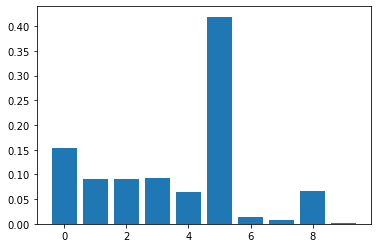

In [27]:
from matplotlib import pyplot
dtc.fit(X_train, y_train)
importance = dtc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Node count = 221


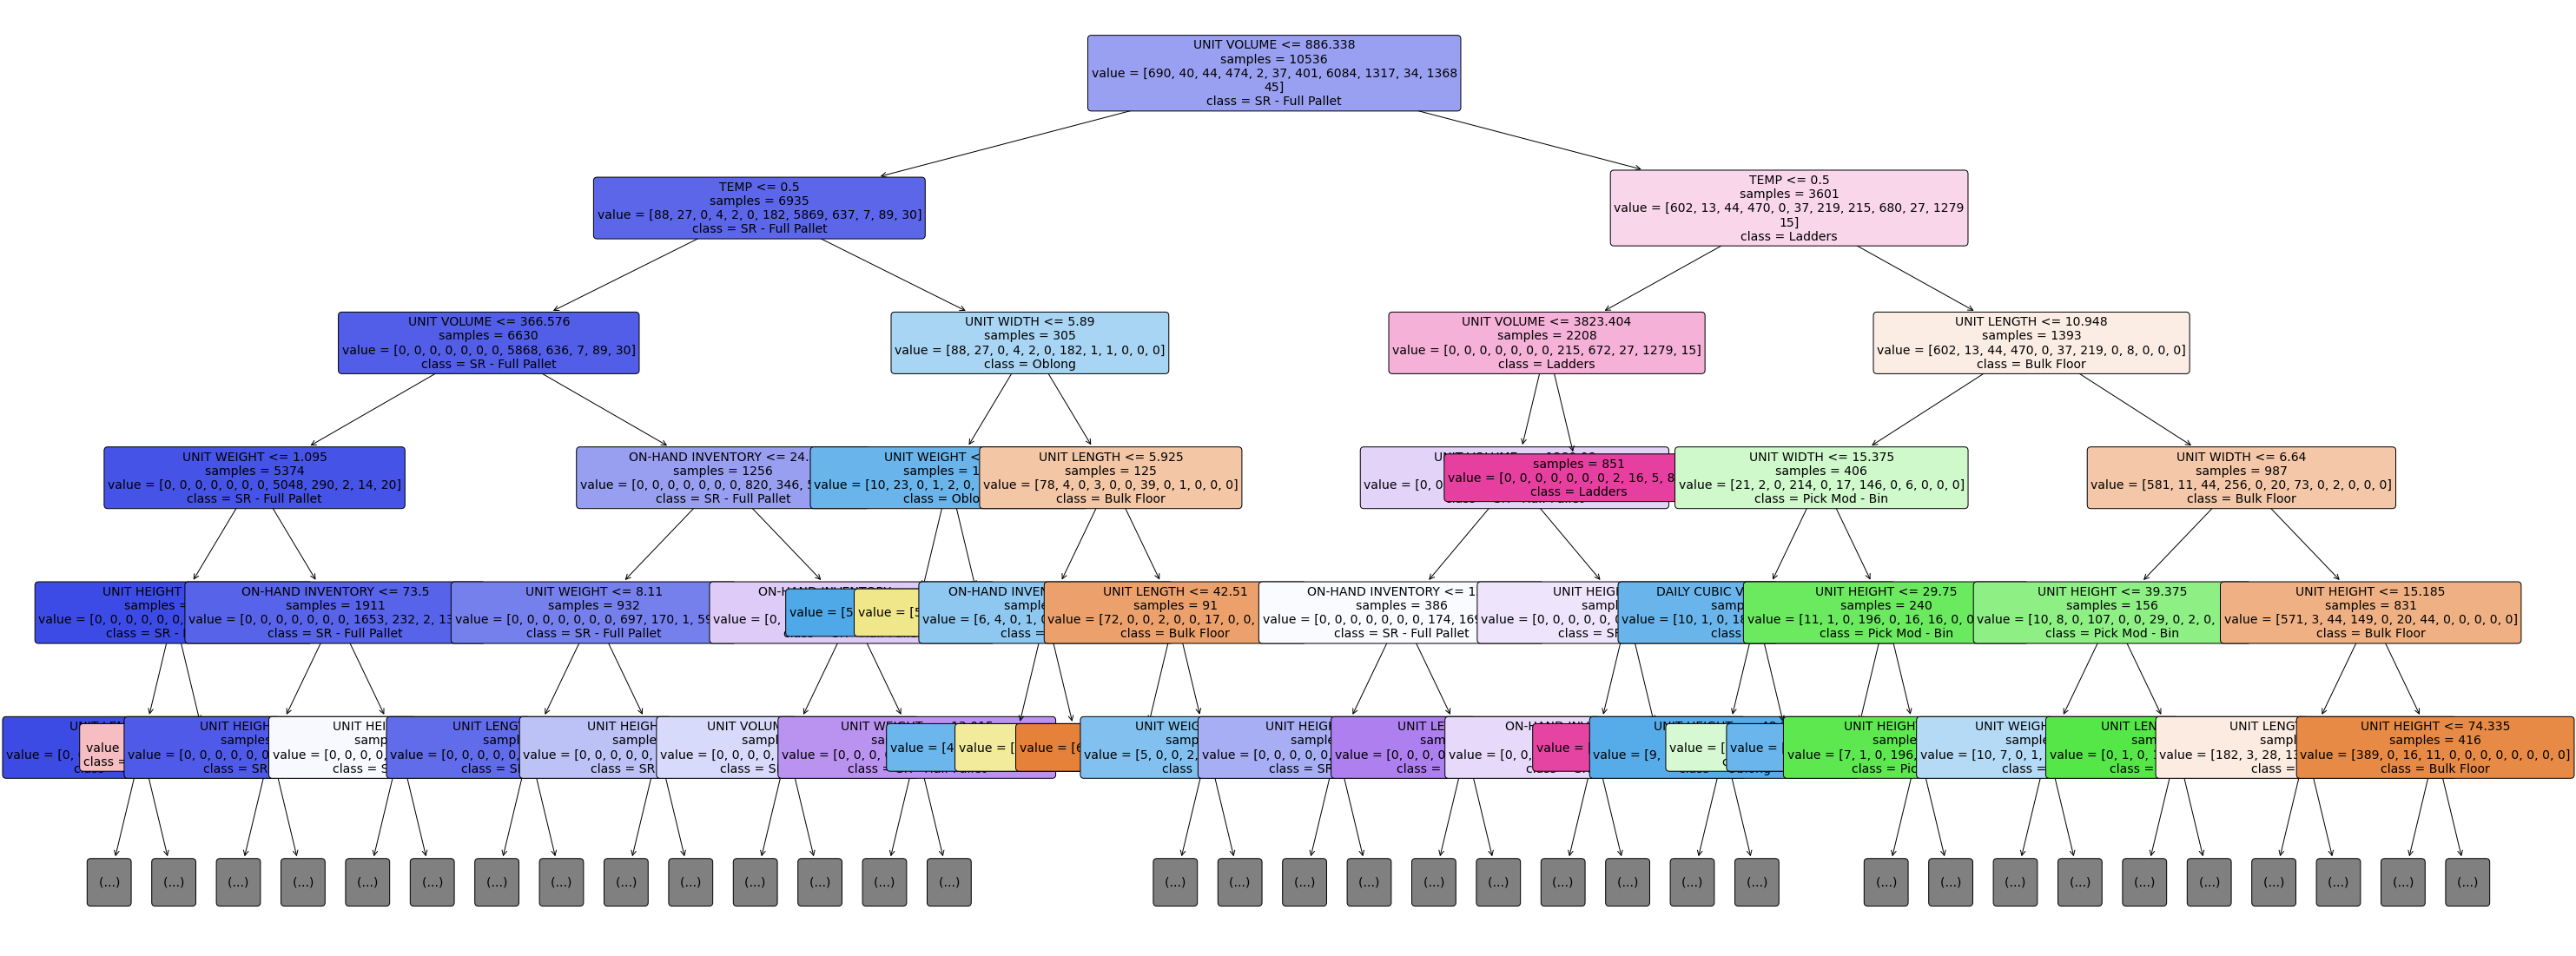

In [28]:
from sklearn.tree import plot_tree
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(50,20))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=pick_data.LOCATION_TYPE.unique(),
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=14,
          max_depth=5)
plt.show()

### Vanilla bagging

In [29]:
rf = RandomForestClassifier(max_features=X_train.shape[1], min_samples_leaf=5, n_estimators=500, random_state=88)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, min_samples_leaf=5, n_estimators=500,
                       random_state=88)

In [30]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix: 
 [[ 172    0    0    5    1    4    0    0    0    0    0]
 [   0    5    0    0    3    1    0    0    0    0    0]
 [   0    0   13    0    0    0    0    0    0    0    0]
 [   3    0    0  133    0    6    0    0    0    0    0]
 [   0    0    0    0    4    0    0    0    0    0    0]
 [   0    1    0    1    0   82    0    0    0    0    0]
 [   1    0    0    0    0    2 1464   48    0    7    0]
 [   0    0    0    0    0    0   92  201    1   34    0]
 [   0    0    0    0    0    0    0    4    0    4    0]
 [   0    0    0    0    0    0   14   42    2  273    0]
 [   0    0    0    0    0    0    4    1    1    5    0]]

Accuracy: 0.8910402429764617


### Random forest with cross-validation

In [31]:
## using GridSearchCV to find best max_features:
grid_values = {'max_features': np.linspace(1,X_train.shape[1],X_train.shape[1], dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

rf2 = RandomForestClassifier() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='accuracy', cv=cv,verbose=1)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=333, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
                         'min_samples_leaf': [5], 'n_estimators': [500],
                         'random_state': [88]},
             scoring='accuracy', verbose=1)

In [32]:
print(rf_cv.best_params_)

{'max_features': 6, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [33]:
print('Cross-validated Accuracy:', round(rf_cv.best_score_, 5))

Cross-validated Accuracy: 0.89512
